In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gpflow
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from xgboost import XGBRegressor
import joblib

2024-06-15 14:21:38.112547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 14:21:38.274643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/apps/22.04/openmpi/4.1.5/lib:/share/apps/22.04/slurm/23.02.7/lib
2024-06-15 14:21:38.274704: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-15 14:21:38.316885: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has al

In [2]:
pfts = ["Tropical", "Temperate_Broadleaf","Temperate_Deciduous"
        ,"Temperate_Coniferous","Boreal"]

In [65]:
input_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/raw/global_input_vars.csv')
future_input_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/raw/whole_time_CanESM5xx1_ssp245_global_input_vars.csv')
future_input_data = future_input_data.loc[future_input_data['year'] >= 2014 ]

In [66]:
print(len(input_data))
print(len(future_input_data))

9854166
2662461


In [67]:
####read in 
pft = pfts[4]

model_data = pd.concat([
  pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/raw/' + pft + '_trainingset_r_1_9.csv')
  , pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/raw/' + pft + '_trainingset_r_10_19.csv')
  , pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/raw/' + pft + '_trainingset_r_20_29.csv')
])



In [68]:
future_model_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/raw/whole_time_ssp245_'+pft+'_trainingset_r_1_29.csv')


In [69]:
print(len(model_data))

print(len(future_model_data))

10685663
10319581


In [70]:
future_model_data['year'].max()

2100

In [71]:
pft

'Boreal'

In [72]:
model_data = model_data[['lon', 'lat', 'year', 'stand_age_interval_min','ordinal_stand_age'
                                                                   , 'current_veg','community_type', 'silt_clay'
                                                                  ,' GPP ', ' NPP ', ' SOILORGC ', ' VEGC ']]

future_model_data = future_model_data[['lon', 'lat', 'year', 'stand_age_interval_min','ordinal_stand_age'
                                                                   , 'current_veg','community_type', 'silt_clay'
                                                                  ,' GPP ', ' NPP ', ' SOILORGC ', ' VEGC ']]

In [73]:

model_data = pd.merge(model_data, input_data, on = ['lon','lat','year'])
future_model_data = pd.merge(future_model_data, future_input_data, on = ['lon','lat','year'])
print(len(model_data))
print(len(future_model_data))


10685663
10319581


In [290]:
print(len(model_data))


2724012


In [223]:
# del future_input_data, input_data

In [74]:
model_data = model_data.loc[model_data['year']>=1900]
# model_data = model_data.loc[model_data['monthly_mean_ratio']<=3]

In [23]:
model_data.columns

Index(['lon', 'lat', 'year', 'stand_age_interval_min', 'ordinal_stand_age',
       'current_veg', 'community_type', 'silt_clay', ' GPP ', ' NPP ',
       ' SOILORGC ', ' VEGC ', 'tswrf_v11_avg', 'tswrf_v11_min',
       'tswrf_v11_max', 'tmp_avg', 'tmp_min', 'tmp_max', 'precip_avg',
       'precip_min', 'precip_max', 'dtr_avg', 'dtr_min', 'dtr_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max', 'Ndep_Trendy',
       'Nfer_crop', 'Nfer_pas', 'var_x', 'Area', 's1', 's2', 's3', 'tt',
       'soil_text', 'region', 'var_y', 'elev', 'co2'],
      dtype='object')

In [317]:
model_data[[' GPP ', ' NPP ', ' SOILORGC ', ' VEGC ']].describe()

,GPP,NPP,SOILORGC,VEGC
count,1.068566e+07,1.068566e+07,1.068566e+07,1.068566e+07
mean,4.694903e+01,1.824144e+01,8.177794e+03,3.092531e+03
std,2.344466e+01,9.628035e+00,2.276300e+03,2.410560e+03
min,0.000000e+00,-2.223000e+01,1.200000e+00,0.000000e+00
25%,3.326000e+01,1.239000e+01,7.227210e+03,1.319580e+03
50%,5.058000e+01,1.975000e+01,8.898990e+03,2.715350e+03
75%,6.293000e+01,2.446000e+01,9.645970e+03,4.495620e+03
max,1.944100e+02,8.167000e+01,1.785558e+04,2.641186e+04


In [318]:
future_model_data[[' GPP ', ' NPP ', ' SOILORGC ', ' VEGC ']].describe()

,GPP,NPP,SOILORGC,VEGC
count,1.031958e+07,1.031958e+07,1.031958e+07,1.031958e+07
mean,6.332455e+01,2.374638e+01,7.716426e+03,3.951589e+03
std,2.787523e+01,1.203383e+01,2.531490e+03,2.640314e+03
min,0.000000e+00,-4.021000e+01,4.580000e+00,0.000000e+00
25%,4.879000e+01,1.679000e+01,5.843910e+03,2.151630e+03
50%,6.658000e+01,2.501000e+01,8.616560e+03,3.733860e+03
75%,8.184000e+01,3.102000e+01,9.628320e+03,5.495280e+03
max,2.318200e+02,1.149700e+02,2.123881e+04,3.204611e+04


In [319]:
#### create a training set for historical, future, and all time
model_data.columns 
model_data.rename(columns={
'tswrf_v11_avg': 'nirr_avg',
'tswrf_v11_min': 'nirr_min',
'tswrf_v11_max': 'nirr_max',
'tmp_avg':'tair_avg',
'tmp_min':'tair_min',
'tmp_max':'tair_max',
'precip_avg':'prec_avg',
'precip_min':'prec_min',
'precip_max':'prec_max',
'dtr_avg':'trange_avg',
'dtr_min':'trange_min',
'dtr_max':'trange_max',
'Ndep_Trendy':'Ndep_rcp45'
}, inplace=True)
model_data.columns 


Index(['lon', 'lat', 'year', 'stand_age_interval_min', 'ordinal_stand_age',
       'current_veg', 'community_type', 'silt_clay', ' GPP ', ' NPP ',
       ' SOILORGC ', ' VEGC ', 'nirr_avg', 'nirr_min', 'nirr_max', 'tair_avg',
       'tair_min', 'tair_max', 'prec_avg', 'prec_min', 'prec_max',
       'trange_avg', 'trange_min', 'trange_max', 'vpr_avg', 'vpr_min',
       'vpr_max', 'wind_avg', 'wind_min', 'wind_max', 'Ndep_rcp45',
       'Nfer_crop', 'Nfer_pas', 'var_x', 'Area', 's1', 's2', 's3', 'tt',
       'soil_text', 'region', 'var_y', 'elev', 'co2'],
      dtype='object')

In [75]:
future_model_data.columns 
future_model_data.drop(columns=['tt', 'soil_text',
       'region', 'var_y', 'var_x'], inplace=True)
model_data.drop(columns=['tt', 'soil_text',
       'region', 'var_y', 'var_x'], inplace=True)

In [229]:
future_model_data.columns 


Index(['lon', 'lat', 'year', 'stand_age_interval_min', 'ordinal_stand_age',
       'current_veg', 'community_type', 'silt_clay', ' GPP ', ' NPP ',
       ' SOILORGC ', ' VEGC ', 'nirr_avg', 'nirr_min', 'nirr_max', 'prec_avg',
       'prec_min', 'prec_max', 'tair_avg', 'tair_min', 'tair_max',
       'trange_avg', 'trange_min', 'trange_max', 'vpr_avg', 'vpr_min',
       'vpr_max', 'wind_avg', 'wind_min', 'wind_max', 'aot40_rcp45_avg',
       'aot40_rcp45_min', 'aot40_rcp45_max', 'Ndep_rcp45', 'Nfer_crop',
       'Nfer_pas', 'Area', 's1', 's2', 's3', 'elev', 'co2'],
      dtype='object')

In [76]:
all_model_data = pd.concat([model_data,future_model_data])
all_model_data.columns = all_model_data.columns.str.strip()

In [77]:
all_model_data['year'].max()

2100

In [5]:
var_list = ['GPP', 'NPP', 'VEGC', 'SOILORGC']


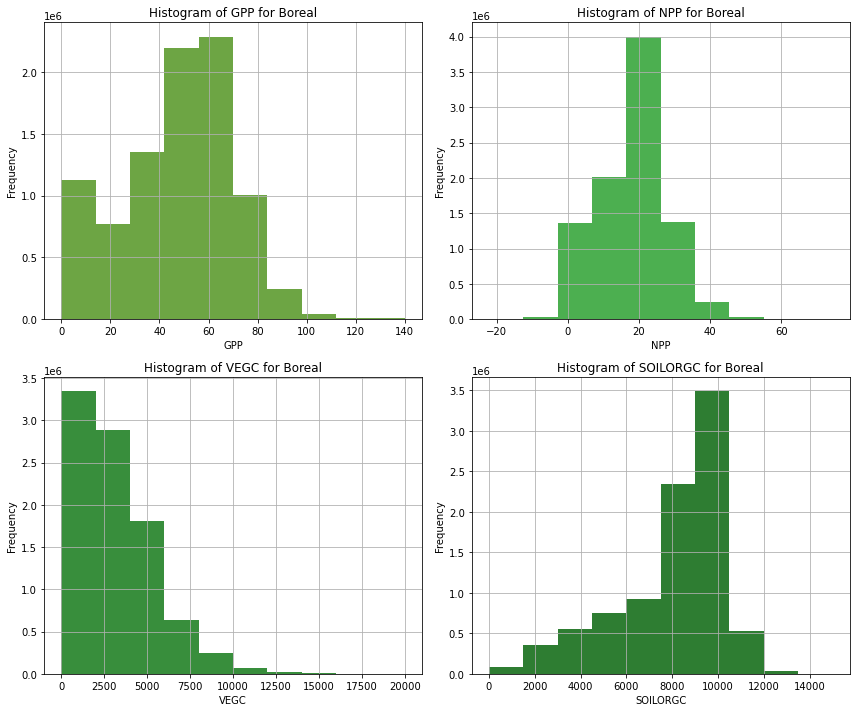

In [10]:

# Different shades of green
shades_of_green = [
   "#6DA544",  # Pleasant green
    "#4CAF50",  # Richer green
    "#388E3C",  # Medium-dark green
    "#2E7D32"   # Solid dark green
]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the axes and corresponding plot information
for ax, var, color in zip(axes, var_list, shades_of_green):
    all_model_data[var].hist(ax=ax, color=color)
    ax.set_title(f'Histogram of {var} for {pft}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [325]:
# ####### drops for temperate coniferous
len(all_model_data[
(all_model_data['SOILORGC'] < 15000) & 
(all_model_data['VEGC'] < 20000) & 
(all_model_data['GPP'] < 140) & 
(all_model_data['NPP'].between(-25, 75)) 
]) / len(all_model_data)

# # ####### drops for temperate coniferous
# len(all_model_data[
# (all_model_data['SOILORGC'] < 15000) & 
# (all_model_data['VEGC'] < 30000) & 
# (all_model_data['GPP'] < 320) & 
# (all_model_data['NPP'].between(-50, 175)) 
# ]) / len(all_model_data)

# ####### drops for temperate coniferous
# len(all_model_data[
# (all_model_data['SOILORGC'] < 15000) & 
# (all_model_data['VEGC'] < 30000) & 
# (all_model_data['GPP'] < 450) & 
# (all_model_data['NPP'].between(-50, 225)) 
# ]) / len(all_model_data)

# ####### drops for temperate coniferous
# len(all_model_data[
# (all_model_data['SOILORGC'] < 15000) & 
# (all_model_data['VEGC'] < 30000) & 
# (all_model_data['GPP'] < 275) & 
# (all_model_data['NPP'].between(-25, 170)) 
# ]) / len(all_model_data)

# ####### drops for tropical
# len(all_model_data[
# (all_model_data['SOILORGC'] < 15000) & 
# (all_model_data['VEGC'] < 35000) & 
# (all_model_data['GPP'] < 325) & 
# (all_model_data['NPP'].between(-25, 220)) 
# ]) / len(all_model_data)

0.9987422188478268

In [326]:
all_model_data = all_model_data[
(all_model_data['SOILORGC'] < 15000) & 
(all_model_data['VEGC'] < 20000) & 
(all_model_data['GPP'] < 140) & 
(all_model_data['NPP'].between(-25, 75)) 
]



In [ ]:
all_model_data.to_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/merged_outliers_removed/'+pft+'_cru_hist_canesm5_ssp245.csv', 
                     index=False)



In [89]:
pft = pfts[0]

all_model_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/merged_outliers_removed/'+pft+'_cru_hist_canesm5_ssp245.csv')

In [90]:
all_model_data['year'].max()

2100

In [80]:
all_model_data['year'].max()

2100

In [81]:
pft

'Boreal'

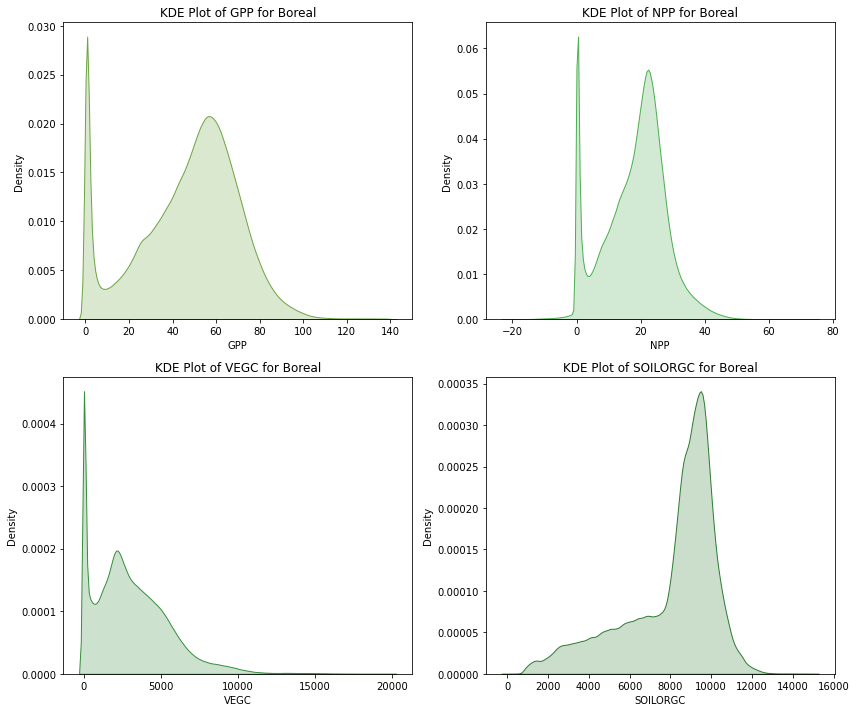

In [11]:

# Different shades of green
shades_of_green = [
    "#6DA544",  # Pleasant green
    "#4CAF50",  # Richer green
    "#388E3C",  # Medium-dark green
    "#2E7D32"   # Solid dark green
]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the axes and corresponding plot information
for ax, var, color in zip(axes, var_list, shades_of_green):
    # Create a KDE plot
    sns.kdeplot(all_model_data[var], ax=ax, color=color, fill=True)
    ax.set_title(f'KDE Plot of {var} for {pft}')
    ax.set_xlabel(var.strip())
    ax.set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()

In [12]:
all_model_data['binned_tair_avg'] = pd.cut(all_model_data['tair_avg'], bins=range(int(all_model_data['tair_avg'].min().round()-1)
                                              , int(all_model_data['tair_avg'].max().round()+3), 3), right=False)

all_model_data['binned_tair_avg'] = all_model_data['binned_tair_avg'].apply(lambda x: x.left).astype(int) + 1

all_model_data['binned_vpr_avg'] = pd.cut(all_model_data['vpr_avg'], bins=range(int(all_model_data['vpr_avg'].min().round()-1)
                                              , int(all_model_data['vpr_avg'].max().round()+3), 3), right=False)

all_model_data['binned_vpr_avg'] = all_model_data['binned_vpr_avg'].apply(lambda x: x.left).astype(int) + 1

all_model_data['binned_co2'] = pd.cut(all_model_data['co2'], bins=range(int(all_model_data['co2'].min().round()-1)
                                              , int(all_model_data['co2'].max().round()+15), 15), right=False)

all_model_data['binned_co2'] = all_model_data['binned_co2'].apply(lambda x: x.left).astype(int) + 1

all_model_data['binned_nirr_avg'] = pd.cut(all_model_data['nirr_avg'], bins=range(int(all_model_data['nirr_avg'].min().round()-1)
                                              , int(all_model_data['nirr_avg'].max().round()+10), 10), right=False)

all_model_data['binned_nirr_avg'] = all_model_data['binned_nirr_avg'].apply(lambda x: x.left).astype(int) + 1

all_model_data['binned_prec_avg'] = pd.cut(all_model_data['prec_avg'], bins=range(int(all_model_data['prec_avg'].min().round()-1)
                                              , int(all_model_data['prec_avg'].max().round()+100), 100), right=False)

all_model_data['binned_prec_avg'] = all_model_data['binned_prec_avg'].apply(lambda x: x.left).astype(int) + 1


In [250]:
var = 'SOILORGC'


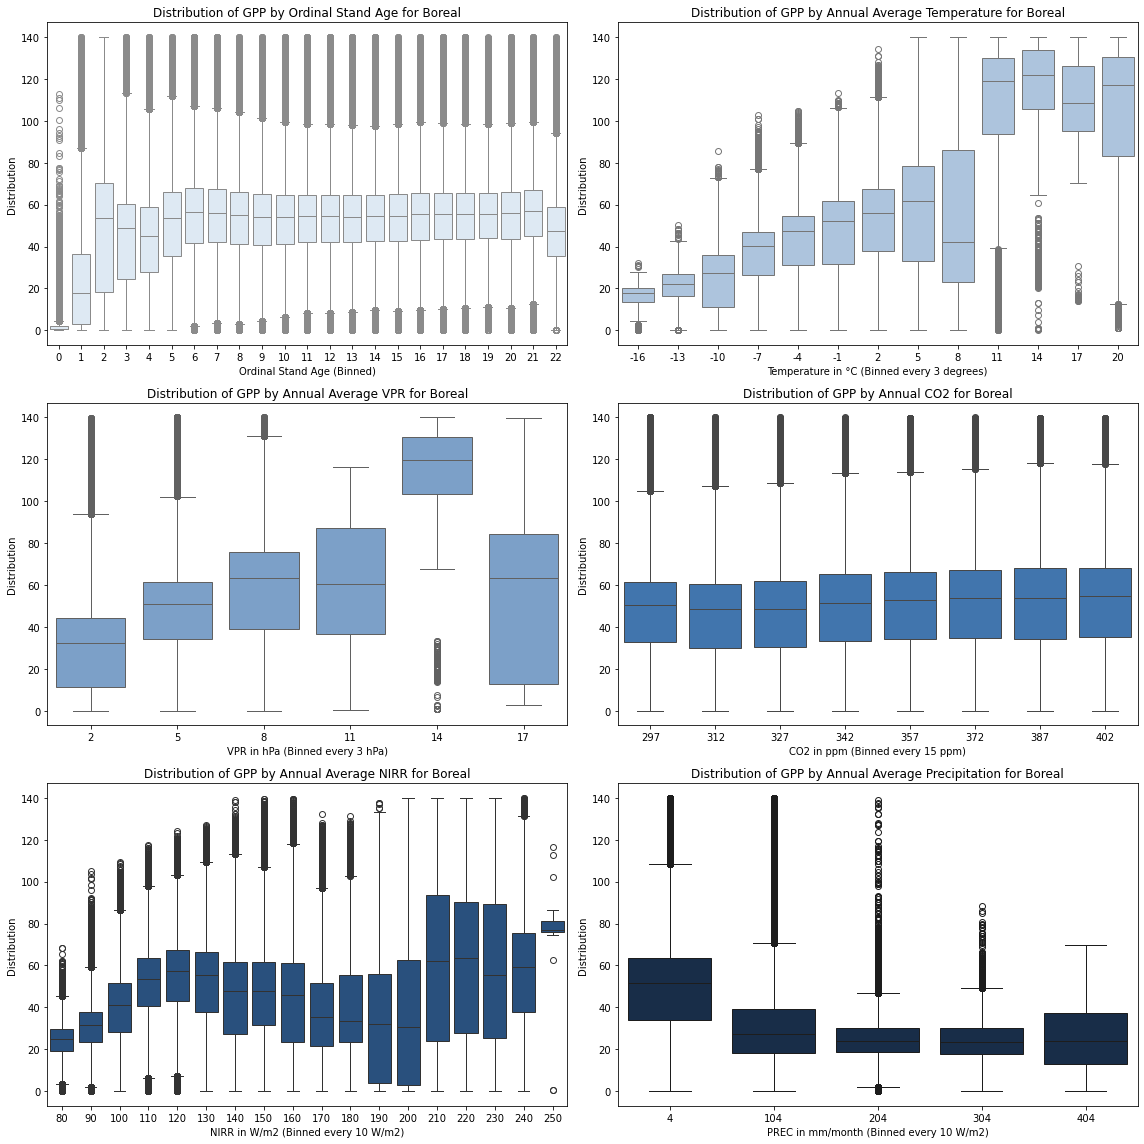

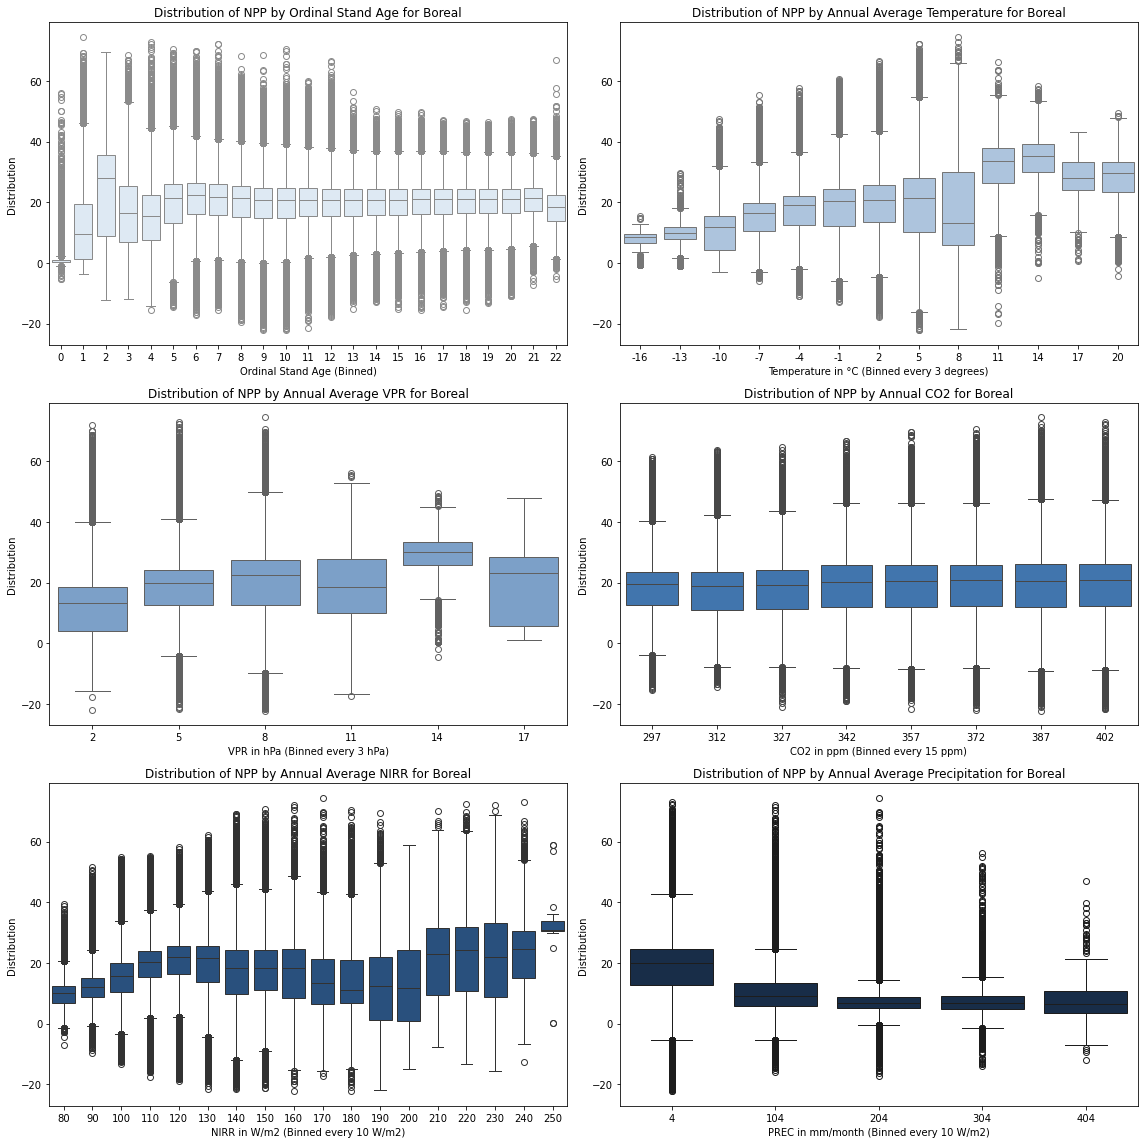

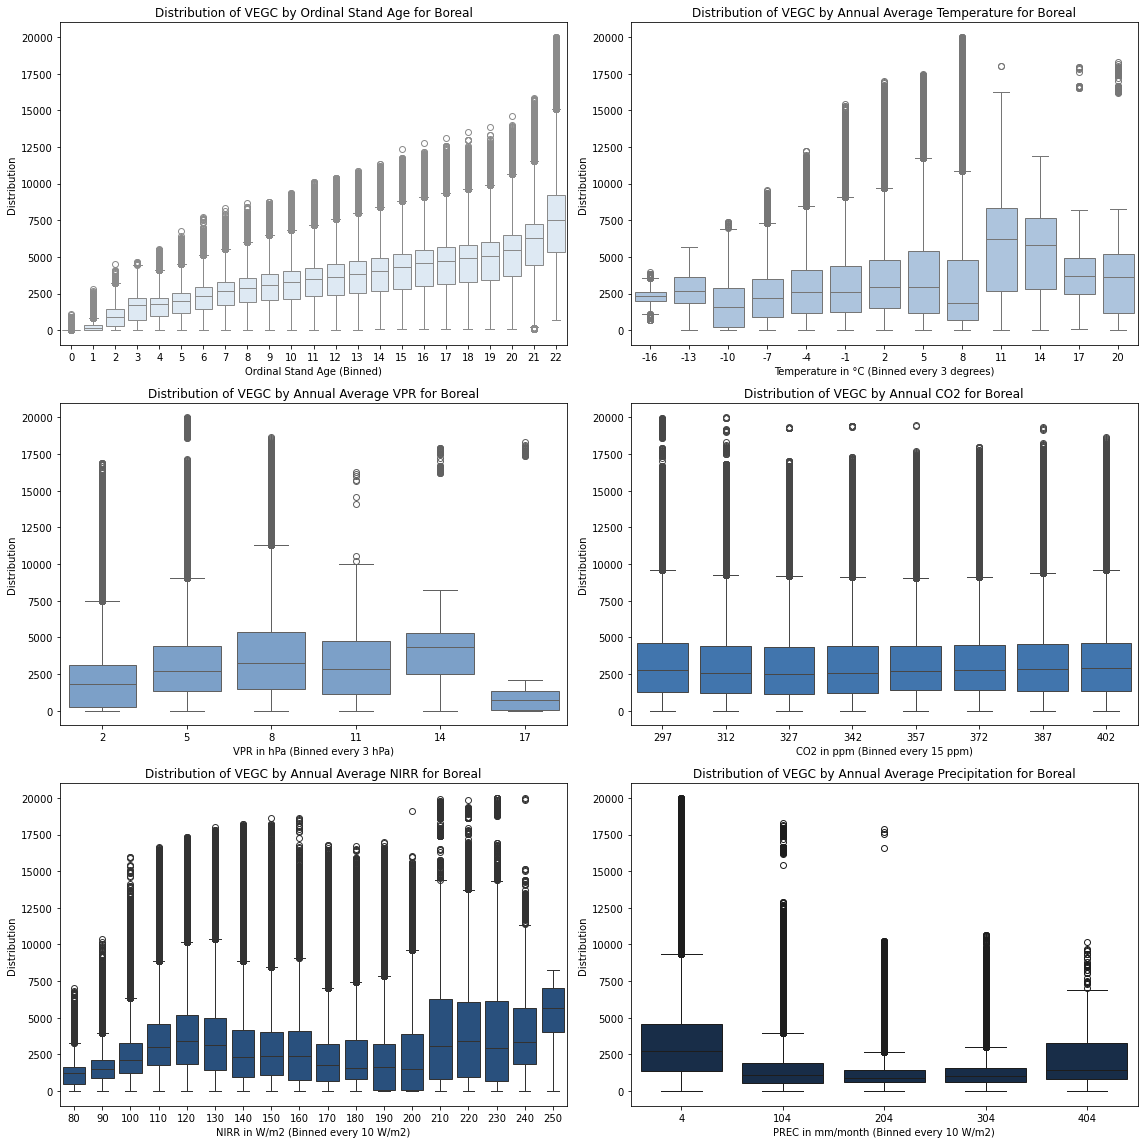

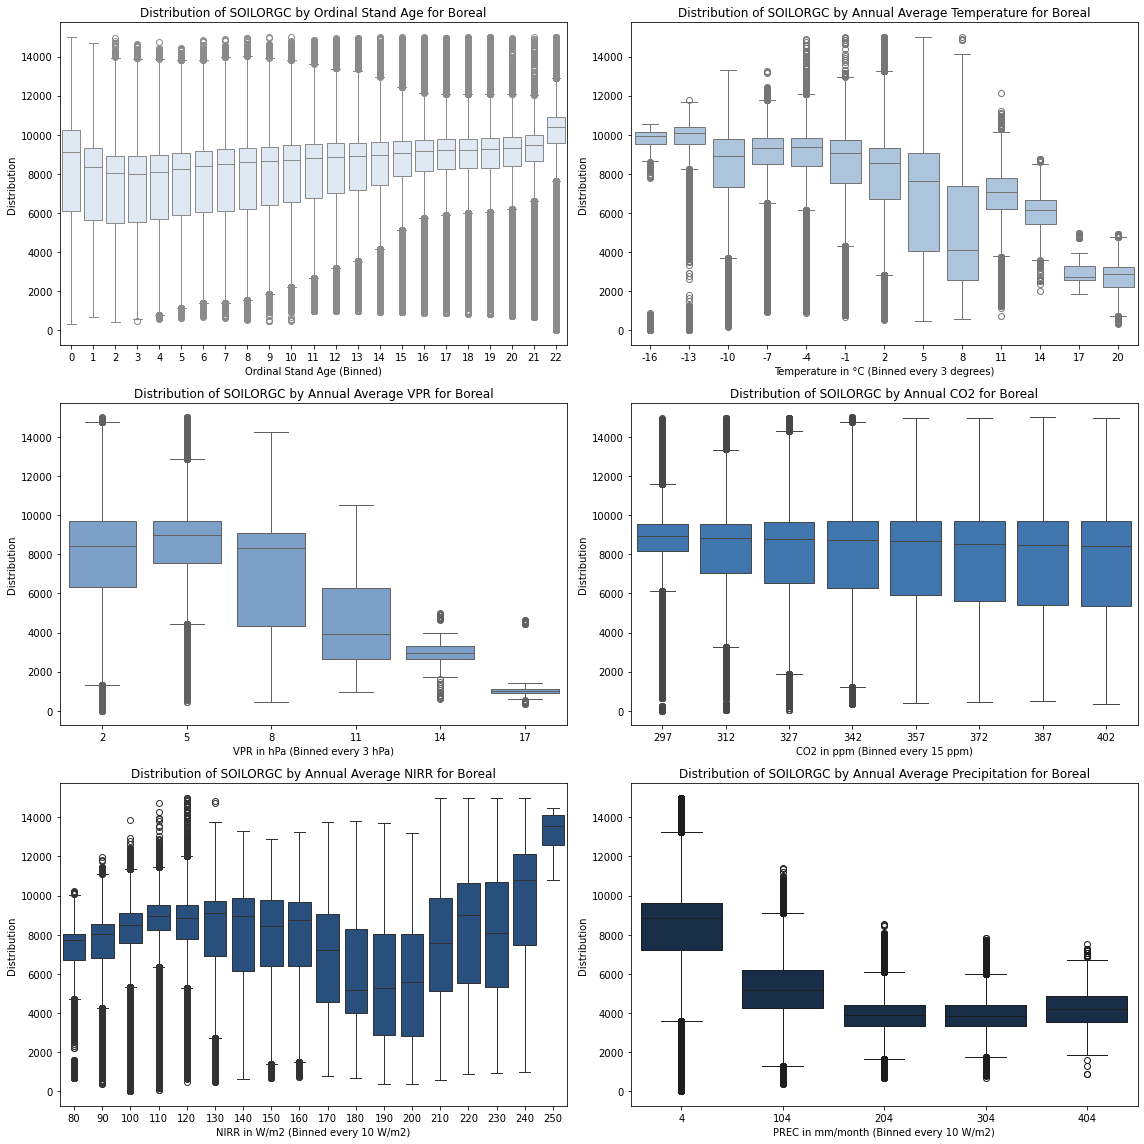

In [13]:
for var in var_list:
    shades_of_blue = [
        "#dbe9f6",  # Light blue
        "#a5c4e5",  # A bit darker
        "#6fa0d5",  # Medium blue
        "#2f74bf",  # Darker medium blue
        "#1b4f8b",  # Dark blue
        "#102c50"   # Darkest blue
    ]


    fig, axes = plt.subplots(3, 2, figsize=(16, 16))

    # List of axes titles, x labels, and y labels
    plots_info = [
        ('ordinal_stand_age', 'Ordinal Stand Age (Binned)', f'Distribution of {var} by Ordinal Stand Age for {pft}'),
        ('binned_tair_avg','Temperature in °C (Binned every 3 degrees)', f'Distribution of {var} by Annual Average Temperature for {pft}'),
        ('binned_vpr_avg', 'VPR in hPa (Binned every 3 hPa)', f'Distribution of {var} by Annual Average VPR for {pft}'),
        ('binned_co2', 'CO2 in ppm (Binned every 15 ppm)', f'Distribution of {var} by Annual CO2 for {pft}'),
        ('binned_nirr_avg', 'NIRR in W/m2 (Binned every 10 W/m2)', f'Distribution of {var} by Annual Average NIRR for {pft}'),
        ('binned_prec_avg', 'PREC in mm/month (Binned every 10 W/m2)', f'Distribution of {var} by Annual Average Precipitation for {pft}')
    ]

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over the axes and corresponding plot information
    # Iterate over the axes and corresponding plot information
    for ax, (col, xlabel, title), color in zip(axes, plots_info, shades_of_blue):
        sns.boxplot(x=col, y=var, data=all_model_data, ax=ax, color=color)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Distribution')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [6]:
# Define the features and target variable
X = all_model_data[['ordinal_stand_age'
                         ,'nirr_avg', 'nirr_min', 'nirr_max', 'prec_avg',
       'prec_min', 'prec_max', 'tair_avg', 'tair_min', 'tair_max',
       'trange_avg', 'trange_min', 'trange_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max','s1', 's2', 'co2']]
Y = all_model_data[var_list]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
# Y = Y.reshape(len(Y),1)


In [52]:
X_train

,ordinal_stand_age,nirr_avg,nirr_min,nirr_max,prec_avg,prec_min,prec_max,tair_avg,tair_min,tair_max,...,trange_max,vpr_avg,vpr_min,vpr_max,wind_avg,wind_min,wind_max,s1,s2,co2
2442829,9,194.05,75.32,298.32,87.94,42.12,167.12,13.67,0.29,26.29,...,7.86,12.61,4.46,22.71,3.67,2.52,5.10,52.00,28.36,465.90
1482227,22,215.74,102.69,293.59,122.21,12.10,270.50,19.77,11.90,27.60,...,8.14,18.57,9.86,29.67,2.81,2.09,3.56,46.54,35.05,304.66
4713822,3,203.75,97.67,291.55,69.61,10.00,223.39,15.25,1.00,28.10,...,8.04,14.39,4.54,30.49,2.62,1.86,3.31,30.86,37.28,310.27
5175632,1,168.21,71.03,274.82,54.03,6.09,155.90,2.41,-19.00,19.30,...,5.80,7.09,0.97,17.50,1.59,1.15,2.07,48.03,26.30,324.94
1787137,3,186.50,91.94,306.26,80.08,0.00,341.11,15.52,-0.94,29.75,...,6.49,11.67,2.46,25.47,1.35,0.85,2.13,38.50,28.76,528.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846734,16,195.47,116.01,306.98,107.37,8.66,241.66,13.92,-0.22,24.98,...,6.29,12.92,4.21,25.95,1.31,0.43,2.24,45.28,26.31,447.23
2236422,9,182.88,109.06,299.24,98.56,8.09,240.00,12.97,-0.70,25.80,...,6.39,11.59,2.96,24.07,1.59,1.22,2.06,47.85,25.37,378.45
4307065,5,208.91,130.26,284.76,83.06,9.20,229.42,11.95,5.50,17.50,...,6.58,7.09,3.67,10.69,1.34,1.00,1.77,45.47,31.86,399.24
1189420,1,242.91,124.77,353.60,26.20,0.00,69.73,20.54,11.76,30.29,...,10.89,11.43,6.90,16.09,3.55,2.79,4.06,45.42,30.41,573.31


In [15]:
X_train.to_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/merged_outliers_removed/'+pft+'_cru_hist_canesm5_ssp245_X_train.csv')
X_test.to_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/merged_outliers_removed/'+pft+'_cru_hist_canesm5_ssp245_X_test.csv')
Y_train.to_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/merged_outliers_removed/'+pft+'_cru_hist_canesm5_ssp245_Y_train.csv')
Y_test.to_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/merged_outliers_removed/'+pft+'_cru_hist_canesm5_ssp245_Y_test.csv')


In [199]:
var = 'NPP'

['/home/smmrrr/TEM_Analysis/TEM_Analysis/models/xgb_model_NPP.joblib']

In [16]:
metrics_list = []

for var in var_list:
    depth = 12
    lr = 0.1
    xgb_model = XGBRegressor(max_depth=depth, learning_rate=lr)

    # Fit the model
    xgb_model.fit(X_train, Y_train[var])

        # Save the model
    model_filename = f'/home/smmrrr/TEM_Analysis/TEM_Analysis/models/xgb_model_{var}_{pft}.joblib'
    joblib.dump(xgb_model, model_filename)
    # Get predictions for X_train and X_test
    Y_train[var+'_pred'] = xgb_model.predict(X_train)
    Y_test[var+'_pred'] = xgb_model.predict(X_test)

    r2_train = r2_score(Y_train[var], Y_train[var+'_pred'])
    r2_test = r2_score(Y_test[var], Y_test[var+'_pred'])
    rmse_train = np.sqrt(mean_squared_error(Y_train[var], Y_train[var+'_pred']))
    rmse_test = np.sqrt(mean_squared_error(Y_test[var], Y_test[var+'_pred']))
    bias_train = np.mean(Y_train[var+'_pred'] - Y_train[var])
    bias_test = np.mean(Y_test[var+'_pred'] - Y_test[var])

    # Store the results in the list
    metrics_list.append({
        'Variable': var,
        'R2 Train': r2_train,
        'R2 Test': r2_test,
        'RMSE Train': rmse_train,
        'RMSE Test': rmse_test,
        'Bias Train': bias_train,
        'Bias Test': bias_test
    })

    # Plot feature importance
    # feature_importances = xgb_model.feature_importances_
    # sorted_idx = np.argsort(feature_importances)
    # plt.figure(figsize=(10, 6))
    # plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center', color='green')
    # plt.yticks(range(len(sorted_idx)), np.array(feature_cols)[sorted_idx])
    # plt.title(f'Feature Importance for {var} for {pft}')
    # plt.xlabel('Importance Value')
    # plt.ylabel('Features')
    # plt.show()
metrics_list

[{'Variable': 'GPP',
  'R2 Train': 0.8824858925600914,
  'R2 Test': 0.8723694641591802,
  'RMSE Train': 8.095663223518864,
  'RMSE Test': 8.431143348272915,
  'Bias Train': 0.00029369330190609803,
  'Bias Test': 0.0002556250751046349},
 {'Variable': 'NPP',
  'R2 Train': 0.8056820792981585,
  'R2 Test': 0.7885861517969976,
  'RMSE Train': 4.2931851850309535,
  'RMSE Test': 4.476578945298677,
  'Bias Train': 8.151763007985889e-05,
  'Bias Test': -0.0002605136719410735},
 {'Variable': 'VEGC',
  'R2 Train': 0.9688627107378281,
  'R2 Test': 0.9659325273966332,
  'RMSE Train': 429.3867743438124,
  'RMSE Test': 448.48822104175184,
  'Bias Train': 0.013730015169658584,
  'Bias Test': 0.6977076241841418},
 {'Variable': 'SOILORGC',
  'R2 Train': 0.8595976450676789,
  'R2 Test': 0.8493053863895761,
  'RMSE Train': 862.7680264461152,
  'RMSE Test': 893.6907142797093,
  'Bias Train': 0.04722742492607014,
  'Bias Test': 0.9069014110459709}]

In [17]:
metrics_list= pd.DataFrame(metrics_list)
metrics_list

,Variable,R2 Train,R2 Test,RMSE Train,RMSE Test,Bias Train,Bias Test
0,GPP,0.882486,0.872369,8.095663,8.431143,0.000294,0.000256
1,NPP,0.805682,0.788586,4.293185,4.476579,0.000082,-0.000261
2,VEGC,0.968863,0.965933,429.386774,448.488221,0.013730,0.697708
3,SOILORGC,0.859598,0.849305,862.768026,893.690714,0.047227,0.906901


In [18]:
metrics_list.to_csv(f'/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/model_output/metrics_list_{pft}.csv', index=False)
Y_train.to_csv(f'/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/model_output/Y_train_{pft}.csv', index=False)
Y_test.to_csv(f'/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/model_output/Y_test_{pft}.csv', index=False)

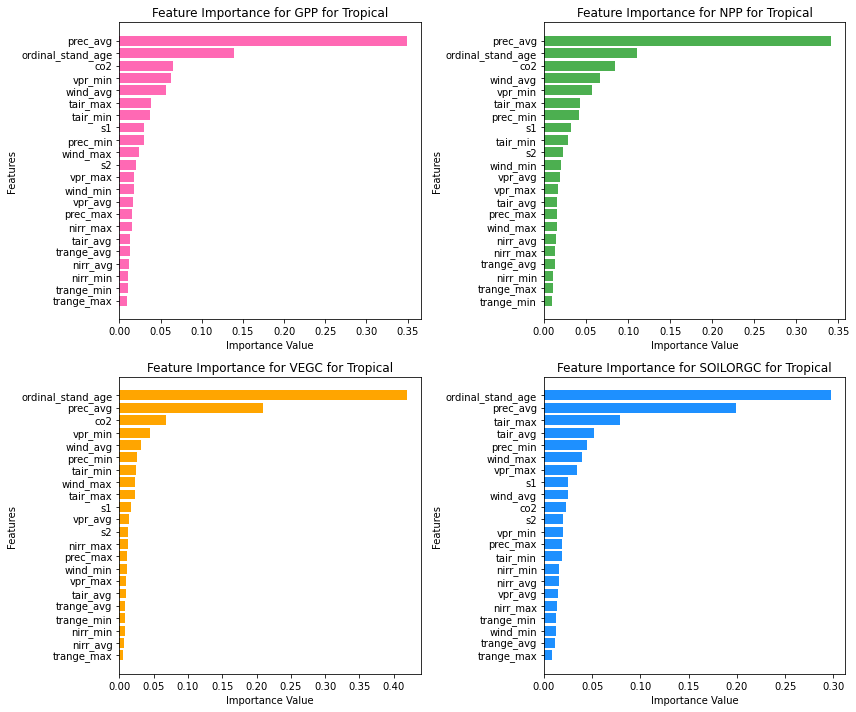

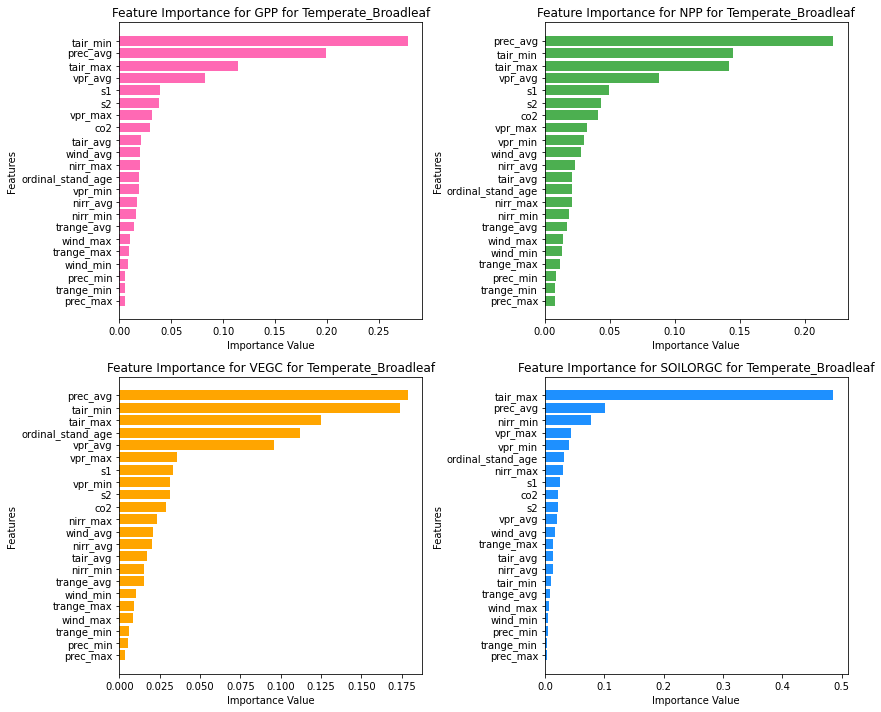

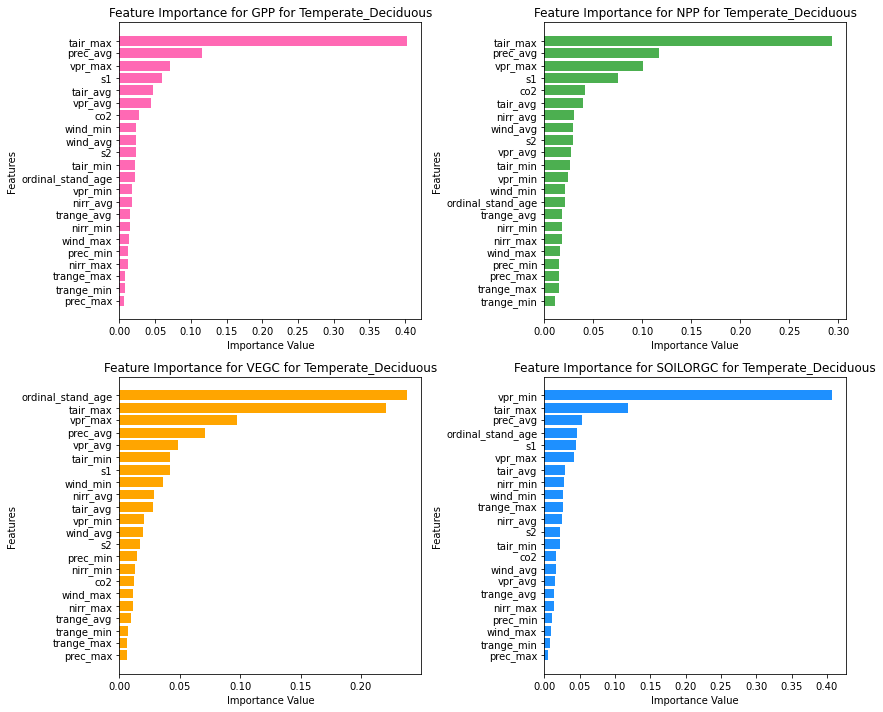

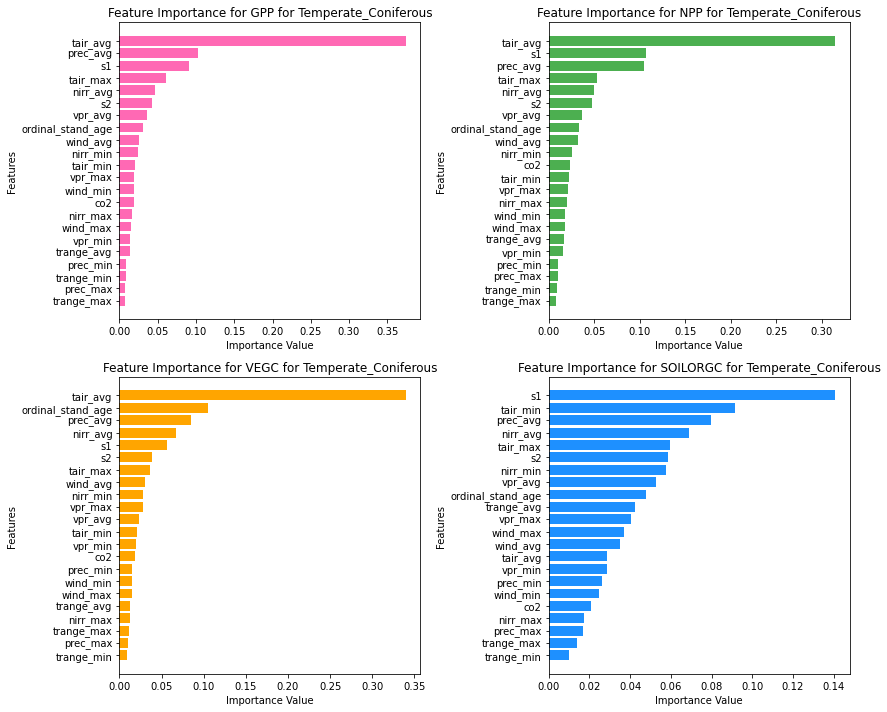

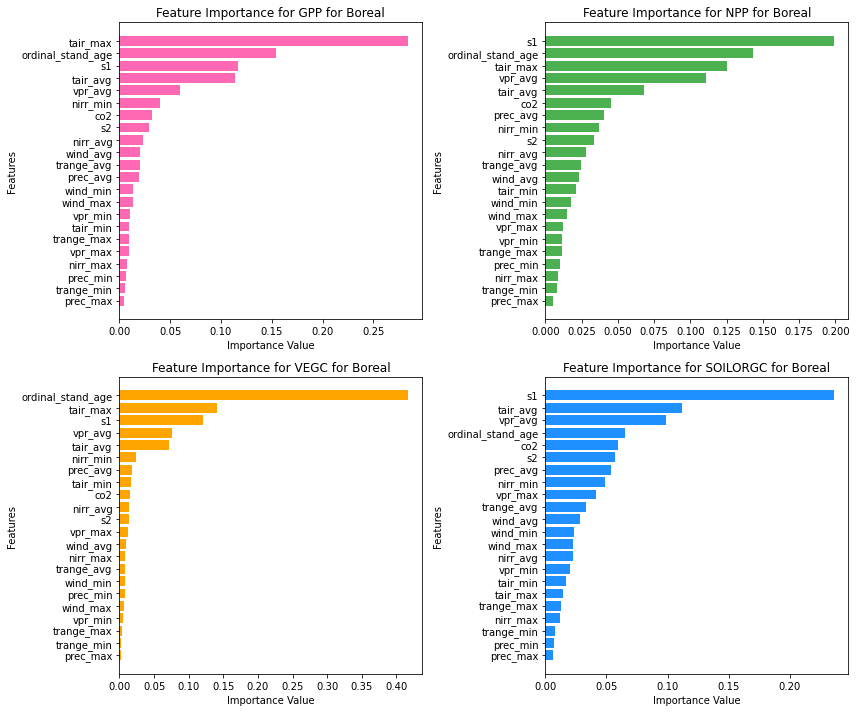

In [23]:
feature_cols = X_train.columns
for i in range(0,5):
    pft = pfts[i]
    model_filenames = [f'/home/smmrrr/TEM_Analysis/TEM_Analysis/models/xgb_model_{var}_{pft}.joblib' for var in var_list]

    # Different colors for the feature importance bars
    colors = ['#FF69B4',  # Medium Pink
              '#4CAF50',  # Medium Green
              '#FFA500',  # Medium Orange
              '#1E90FF']  # Medium Blue

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for ax, var, model_filename, color in zip(axes, var_list, model_filenames, colors):
        # Load the model
        xgb_model = joblib.load(model_filename)

        # Plot feature importance
        feature_importances = xgb_model.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        ax.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center', color=color)
        ax.set_yticks(range(len(sorted_idx)))
        ax.set_yticklabels(np.array(feature_cols)[sorted_idx])
        ax.set_title(f'Feature Importance for {var} for {pft}')
        ax.set_xlabel('Importance Value')
        ax.set_ylabel('Features')

    # Adjust layout
    fig.tight_layout()
    plt.show()



In [8]:
var = 'NPP'


In [12]:
results = pd.DataFrame(columns=["depth", "learning_rate", "train_score", "test_score"])
for depth in range(4, 21, 2):
    for lr in [0.01, 0.1, 0.2, 0.3]:

        xgb_model = XGBRegressor(max_depth=depth,learning_rate=lr)

        # Fit the model on the scaled data
        xgb_model.fit(X_train, Y_train[var])

        # Compute the scores
        train_score = xgb_model.score(X_train, Y_train[var])
        test_score = xgb_model.score(X_test, Y_test[var])
        
        # Append the results to the DataFrame
        results = results.append({
            "depth": depth,
            "learning_rate": lr,
            "train_score": train_score,
            "test_score": test_score
        }, ignore_index=True)
    print(depth)
# Display the DataFrame
print(results)



/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


4


/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


6


/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


8


/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


10


/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


12


/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


14


/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_1592016/1519615674.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


16


KeyboardInterrupt: 

In [13]:
print(results)


    depth  learning_rate  train_score  test_score
0     4.0           0.01     0.371083    0.370210
1     4.0           0.10     0.559768    0.558767
2     4.0           0.20     0.592080    0.591161
3     4.0           0.30     0.603794    0.602877
4     6.0           0.01     0.426643    0.425700
5     6.0           0.10     0.624226    0.623066
6     6.0           0.20     0.654776    0.653139
7     6.0           0.30     0.667450    0.665360
8     8.0           0.01     0.467783    0.466712
9     8.0           0.10     0.681362    0.678607
10    8.0           0.20     0.719617    0.715055
11    8.0           0.30     0.737594    0.731929
12   10.0           0.01     0.510144    0.508350
13   10.0           0.10     0.743640    0.736498
14   10.0           0.20     0.783615    0.771935
15   10.0           0.30     0.801896    0.786420
16   12.0           0.01     0.551488    0.547629
17   12.0           0.10     0.805682    0.788586
18   12.0           0.20     0.848483    0.821876


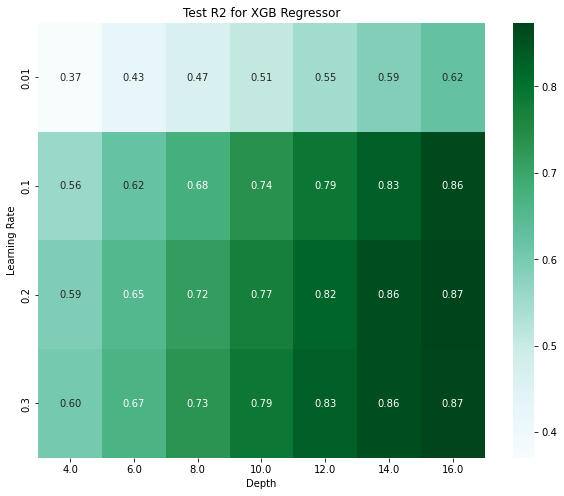

In [16]:
pivot_table = results.pivot("learning_rate", "depth", "test_score")

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="BuGn")

plt.title("Test R2 for XGB Regressor")
plt.xlabel("Depth")
plt.ylabel("Learning Rate")
plt.show()

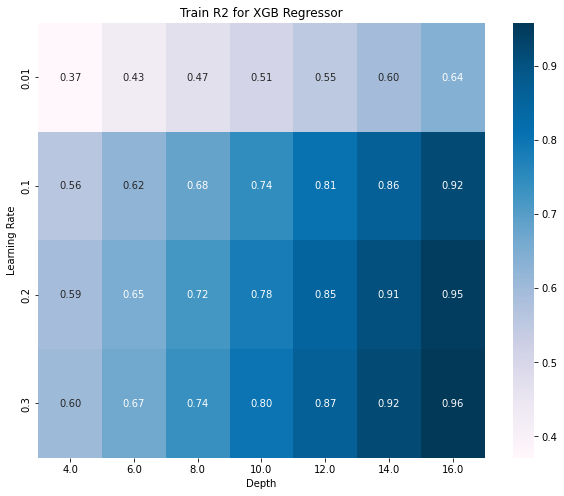

In [17]:
pivot_table = results.pivot("learning_rate", "depth", "train_score")

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="PuBu")

plt.title("Train R2 for XGB Regressor")
plt.xlabel("Depth")
plt.ylabel("Learning Rate")
plt.show()

In [22]:
####### train test split for future and past
past_future_results = pd.DataFrame()

for var in var_list:

    X_train = all_model_data.loc[all_model_data['year']<=2014, ['ordinal_stand_age'
                         ,'nirr_avg', 'nirr_min', 'nirr_max', 'prec_avg',
       'prec_min', 'prec_max', 'tair_avg', 'tair_min', 'tair_max',
       'trange_avg', 'trange_min', 'trange_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max','s1', 's2', 'co2']]
    Y_train = all_model_data.loc[all_model_data['year']<=2014,var_list]

    X_test = all_model_data.loc[all_model_data['year']>2014, ['ordinal_stand_age'
                         ,'nirr_avg', 'nirr_min', 'nirr_max', 'prec_avg',
       'prec_min', 'prec_max', 'tair_avg', 'tair_min', 'tair_max',
       'trange_avg', 'trange_min', 'trange_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max','s1', 's2', 'co2']]
    Y_test = all_model_data.loc[all_model_data['year']>2014,var_list]


    depth = 12
    lr = 0.1
    xgb_model = XGBRegressor(max_depth=depth, learning_rate=lr)

    xgb_model.fit(X_train, Y_train[var])

    #     # Save the model
    # model_filename = f'/home/smmrrr/TEM_Analysis/TEM_Analysis/models/xgb_model_{var}_{pft}.joblib'
    # joblib.dump(xgb_model, model_filename)
    # Get predictions for X_train and X_test
    Y_train[var+'_pred'] = xgb_model.predict(X_train)
    Y_test[var+'_pred'] = xgb_model.predict(X_test)

    r2_train = r2_score(Y_train[var], Y_train[var+'_pred'])
    r2_test = r2_score(Y_test[var], Y_test[var+'_pred'])
    rmse_train = np.sqrt(mean_squared_error(Y_train[var], Y_train[var+'_pred']))
    rmse_test = np.sqrt(mean_squared_error(Y_test[var], Y_test[var+'_pred']))
    bias_train = np.mean(Y_train[var+'_pred'] - Y_train[var])
    bias_test = np.mean(Y_test[var+'_pred'] - Y_test[var])

    past_future_results = pd.concat([past_future_results, pd.DataFrame({
    'Variable': [var],
    'R2 Train': [r2_train],
    'R2 Test': [r2_test],
    'RMSE Train': [rmse_train],
    'RMSE Test': [rmse_test],
    'Bias Train': [bias_train],
    'Bias Test': [bias_test]
    })
                                ])

past_future_results

,Variable,R2 Train,R2 Test,RMSE Train,RMSE Test,Bias Train,Bias Test
0,GPP,0.887058,0.714753,7.890656,13.319450,0.000221,0.569897
0,NPP,0.813722,0.596722,4.162140,6.868541,0.000066,0.342160
0,VEGC,0.970642,0.893360,416.481182,799.642039,0.011381,48.008081
0,SOILORGC,0.864717,0.725943,835.197019,1377.183158,0.036216,-9.329618


In [23]:
####### train test split for future and past
future_results = pd.DataFrame()

X_train, X_test, Y_train, Y_test = train_test_split(
    all_model_data.loc[all_model_data['year']>2014, ['ordinal_stand_age'
                         ,'nirr_avg', 'nirr_min', 'nirr_max', 'prec_avg',
       'prec_min', 'prec_max', 'tair_avg', 'tair_min', 'tair_max',
       'trange_avg', 'trange_min', 'trange_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max','s1', 's2', 'co2']]
    , all_model_data.loc[all_model_data['year']>2014,var_list]
    , test_size=0.15, random_state=42)

for var in var_list:

    depth = 12
    lr = 0.1
    xgb_model = XGBRegressor(max_depth=depth, learning_rate=lr)

    xgb_model.fit(X_train, Y_train[var])

    #     # Save the model
    # model_filename = f'/home/smmrrr/TEM_Analysis/TEM_Analysis/models/xgb_model_{var}_{pft}.joblib'
    # joblib.dump(xgb_model, model_filename)
    # Get predictions for X_train and X_test
    Y_train[var+'_pred'] = xgb_model.predict(X_train)
    Y_test[var+'_pred'] = xgb_model.predict(X_test)

    r2_train = r2_score(Y_train[var], Y_train[var+'_pred'])
    r2_test = r2_score(Y_test[var], Y_test[var+'_pred'])
    rmse_train = np.sqrt(mean_squared_error(Y_train[var], Y_train[var+'_pred']))
    rmse_test = np.sqrt(mean_squared_error(Y_test[var], Y_test[var+'_pred']))
    bias_train = np.mean(Y_train[var+'_pred'] - Y_train[var])
    bias_test = np.mean(Y_test[var+'_pred'] - Y_test[var])

    future_results = pd.concat([future_results, pd.DataFrame({
    'Variable': [var],
    'R2 Train': [r2_train],
    'R2 Test': [r2_test],
    'RMSE Train': [rmse_train],
    'RMSE Test': [rmse_test],
    'Bias Train': [bias_train],
    'Bias Test': [bias_test]
    })
                                ])

future_results

,Variable,R2 Train,R2 Test,RMSE Train,RMSE Test,Bias Train,Bias Test
0,GPP,0.927095,0.884714,6.733139,8.471677,0.001390,0.022260
0,NPP,0.877937,0.811414,3.778834,4.696701,0.000639,0.010180
0,VEGC,0.979545,0.966759,350.169250,446.765637,0.047680,-1.577270
0,SOILORGC,0.942074,0.913945,633.187786,771.462724,0.177265,2.906863


In [25]:
all_time_results = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/model_output/metrics_list_Boreal.csv')

In [28]:
all_time_results['period'] = 'all_time'
past_future_results['period'] = 'historical_train_future_test'
future_results['period'] = 'future_only'

model_compare = pd.concat([all_time_results, past_future_results, future_results])

In [29]:
model_compare

,Variable,R2 Train,R2 Test,RMSE Train,RMSE Test,Bias Train,Bias Test,period
0,GPP,0.882486,0.872369,8.095663,8.431143,0.000294,0.000256,all_time
1,NPP,0.805682,0.788586,4.293185,4.476579,0.000082,-0.000261,all_time
2,VEGC,0.968863,0.965933,429.386774,448.488221,0.013730,0.697708,all_time
3,SOILORGC,0.859598,0.849305,862.768026,893.690714,0.047227,0.906901,all_time
0,GPP,0.887058,0.714753,7.890656,13.319450,0.000221,0.569897,historical_train_future_test
0,NPP,0.813722,0.596722,4.162140,6.868541,0.000066,0.342160,historical_train_future_test
0,VEGC,0.970642,0.893360,416.481182,799.642039,0.011381,48.008081,historical_train_future_test
0,SOILORGC,0.864717,0.725943,835.197019,1377.183158,0.036216,-9.329618,historical_train_future_test
0,GPP,0.927095,0.884714,6.733139,8.471677,0.001390,0.022260,future_only
0,NPP,0.877937,0.811414,3.778834,4.696701,0.000639,0.010180,future_only


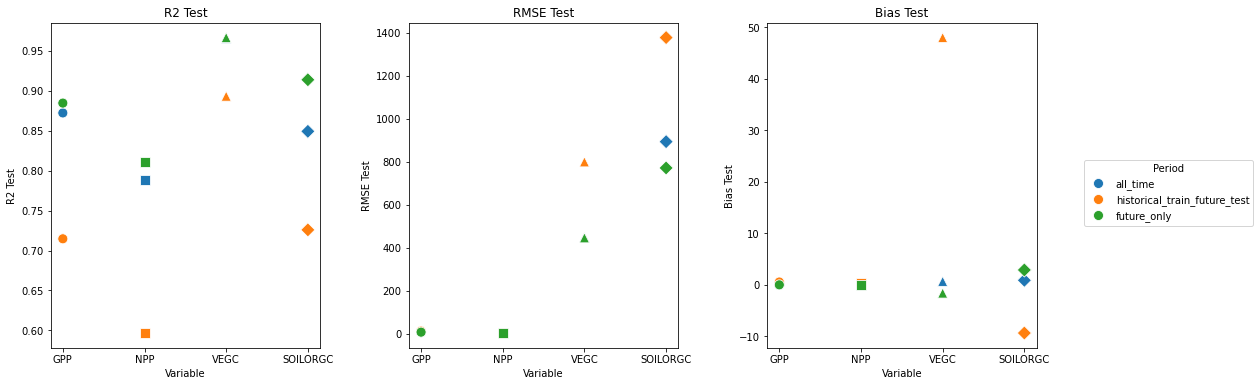

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# List of columns to plot and their respective titles
columns = ['R2 Test', 'RMSE Test', 'Bias Test']
titles = ['R2 Test', 'RMSE Test', 'Bias Test']

# Markers for each variable
markers = {var: marker for var, marker in zip(model_compare['Variable'].unique(), ['o', 's', '^', 'D'])}

for idx, (col, title) in enumerate(zip(columns, titles)):
    sns.scatterplot(
        data=model_compare,
        x='Variable',
        y=col,
        hue='period',
        style='Variable',
        markers=markers,
        s=100,  # Increase marker size
        ax=axs[idx]
    )
    axs[idx].set_title(title)
    axs[idx].legend_.remove()  # Remove legends from individual plots

# Create a custom legend only for the 'period' column
handles, labels = axs[0].get_legend_handles_labels()
# Extract unique handles and labels for 'period'
period_handles = {}
for handle, label in zip(handles, labels):
    if label in model_compare['period'].unique() and label not in period_handles:
        period_handles[label] = handle

# Add the custom legend
fig.legend(period_handles.values(), period_handles.keys(), loc='center left', bbox_to_anchor=(.85, 0.5), title="Period")

# Adjust layout for better readability
fig.tight_layout(pad=3.0, rect=[0, 0, 0.85, 1])  # Adjust the rect parameter to make room for the legend



plt.show()

In [40]:
model_compare['period'].unique()

array(['all_time', 'historical_train_future_test', 'future_only'],
      dtype=object)

In [91]:
### get 15% hold out
pred_vars = ['ordinal_stand_age'
                         ,'nirr_avg', 'nirr_min', 'nirr_max', 'prec_avg',
       'prec_min', 'prec_max', 'tair_avg', 'tair_min', 'tair_max',
       'trange_avg', 'trange_min', 'trange_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max','s1', 's2', 'co2']
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
# Get the indices and split them
indices = np.arange(len(all_model_data))
indices
train_indices, test_indices = train_test_split(indices, test_size=0.15, random_state=42)

# # Split the data using train_indices and test_indices
X_train, X_test = all_model_data.loc[train_indices,pred_vars], all_model_data.loc[test_indices,pred_vars]
Y_train, Y_test = all_model_data.loc[train_indices, var_list], all_model_data.loc[test_indices, var_list]

train_all_model_data = all_model_data.loc[train_indices]


In [92]:
var = 'NPP'
pft

'Tropical'

In [93]:
train_all_model_data['year'].max()

2100

In [94]:
year_results = pd.DataFrame()

for year in range(1920, 2101, 20):
    print(year)

    X_train_sub = train_all_model_data.loc[train_all_model_data['year']<=year,pred_vars]
    Y_train_sub = train_all_model_data.loc[train_all_model_data['year']<=year, var_list]

    xgb_model.fit(X_train_sub, Y_train_sub[var])

    #     # Save the model
    # model_filename = f'/home/smmrrr/TEM_Analysis/TEM_Analysis/models/xgb_model_{var}_{pft}.joblib'
    # joblib.dump(xgb_model, model_filename)
    # Get predictions for X_train and X_test
    Y_train_sub[var+'_pred'] = xgb_model.predict(X_train_sub)
    Y_test[var+'_pred'] = xgb_model.predict(X_test)

    r2_train = r2_score(Y_train_sub[var], Y_train_sub[var+'_pred'])
    r2_test = r2_score(Y_test[var], Y_test[var+'_pred'])
    rmse_train = np.sqrt(mean_squared_error(Y_train_sub[var], Y_train_sub[var+'_pred']))
    rmse_test = np.sqrt(mean_squared_error(Y_test[var], Y_test[var+'_pred']))
    bias_train = np.mean(Y_train_sub[var+'_pred'] - Y_train_sub[var])
    bias_test = np.mean(Y_test[var+'_pred'] - Y_test[var])

# Store the results in the list
    year_results = pd.concat([year_results, pd.DataFrame({
        'Variable': [var],
        'year': [year],
        'R2 Train': [r2_train],
        'R2 Test': [r2_test],
        'RMSE Train': [rmse_train],
        'RMSE Test': [rmse_test],
        'Bias Train': [bias_train],
        'Bias Test': [bias_test]
    })])
year_results.to_csv(f'/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/model_output/year_results_{pft}_{var}.csv', index=False)
year_results

1920
1940
1960
1980
2000
2020
2040
2060
2080
2100


,Variable,year,R2 Train,R2 Test,RMSE Train,RMSE Test,Bias Train,Bias Test
0,NPP,1920,0.921874,0.375427,8.906228,27.996335,0.000678,-10.571672
0,NPP,1940,0.896168,0.404596,10.037619,27.334786,0.000370,-11.032708
0,NPP,1960,0.879395,0.441827,10.579455,26.466358,0.000345,-8.181162
0,NPP,1980,0.866953,0.495006,10.977982,25.174034,0.000332,-8.332942
0,NPP,2000,0.854153,0.584204,11.574747,22.842824,0.000154,-4.323078
0,NPP,2020,0.839468,0.641728,12.505532,21.203924,0.000130,-3.413414
0,NPP,2040,0.832545,0.728225,13.117923,18.467762,0.000157,-1.394892
0,NPP,2060,0.826007,0.758125,13.914835,17.422295,0.000167,-0.675062
0,NPP,2080,0.816370,0.791226,14.874411,16.186314,0.000149,-0.040876
0,NPP,2100,0.810140,0.800665,15.429630,15.816160,0.000127,-0.000689


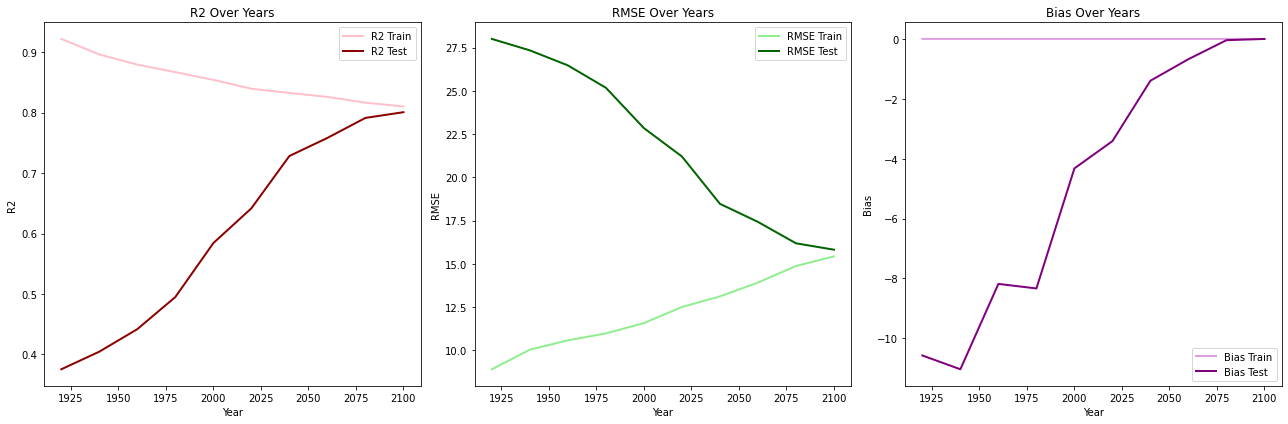

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot R2 Train and Test with pink color
axs[0].plot(year_results['year'], year_results['R2 Train'], label='R2 Train', color='pink', linestyle='-', linewidth=2)
axs[0].plot(year_results['year'], year_results['R2 Test'], label='R2 Test', color='darkred', linestyle='-', linewidth=2)
axs[0].set_title('R2 Over Years')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('R2')
axs[0].legend()

# Plot RMSE Train and Test with green color
axs[1].plot(year_results['year'], year_results['RMSE Train'], label='RMSE Train', color='lightgreen', linestyle='-', linewidth=2)
axs[1].plot(year_results['year'], year_results['RMSE Test'], label='RMSE Test', color='darkgreen', linestyle='-', linewidth=2)
axs[1].set_title('RMSE Over Years')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# Plot Bias Train and Test with orange color
axs[2].plot(year_results['year'], year_results['Bias Train'], label='Bias Train', color='plum', linestyle='-', linewidth=2)
axs[2].plot(year_results['year'], year_results['Bias Test'], label='Bias Test', color='purple', linestyle='-', linewidth=2)
axs[2].set_title('Bias Over Years')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Bias')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [102]:
percentile_results = pd.DataFrame()

for percentile in [.2, .3, .4, .5, .6, .7, .8, .9, 1]:
    print(percentile)
    X_train_sub, X_test_sub, Y_train_sub, Y_test_sub = train_test_split(X_train, Y_train
                    , test_size=percentile, random_state=42)


    xgb_model.fit(X_train_sub, Y_train_sub[var])

    #     # Save the model
    # model_filename = f'/home/smmrrr/TEM_Analysis/TEM_Analysis/models/xgb_model_{var}_{pft}.joblib'
    # joblib.dump(xgb_model, model_filename)
    # Get predictions for X_train_sub and X_test
    Y_train_sub[var+'_pred'] = xgb_model.predict(X_train_sub)
    Y_test[var+'_pred'] = xgb_model.predict(X_test)

    r2_train = r2_score(Y_train_sub[var], Y_train_sub[var+'_pred'])
    r2_test = r2_score(Y_test[var], Y_test[var+'_pred'])
    rmse_train = np.sqrt(mean_squared_error(Y_train_sub[var], Y_train_sub[var+'_pred']))
    rmse_test = np.sqrt(mean_squared_error(Y_test[var], Y_test[var+'_pred']))
    bias_train = np.mean(Y_train_sub[var+'_pred'] - Y_train_sub[var])
    bias_test = np.mean(Y_test[var+'_pred'] - Y_test[var])

    # Store the results in the list
    percentile_results = pd.concat([percentile_results, pd.DataFrame({
        'Variable': [var],
        'percentile': [percentile],
        'R2 Train': [r2_train],
        'R2 Test': [r2_test],
        'RMSE Train': [rmse_train],
        'RMSE Test': [rmse_test],
        'Bias Train': [bias_train],
        'Bias Test': [bias_test]
    })])

percentile_results.to_csv(f'/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/model_output/percentile_results_{pft}_{var}.csv', index=False)

0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


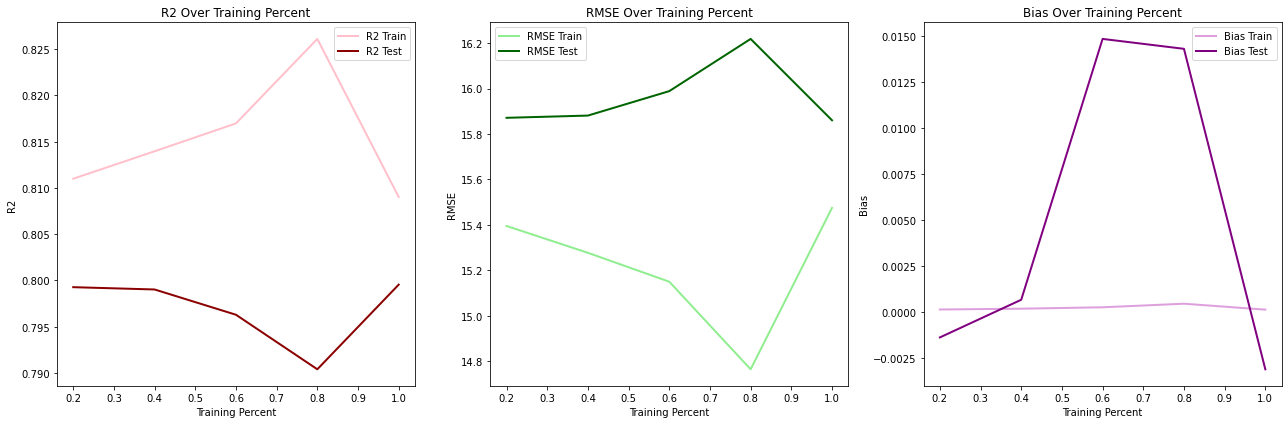

In [101]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot R2 Train and Test with pink color
axs[0].plot(percentile_results['percentile'], percentile_results['R2 Train'], label='R2 Train', color='pink', linestyle='-', linewidth=2)
axs[0].plot(percentile_results['percentile'], percentile_results['R2 Test'], label='R2 Test', color='darkred', linestyle='-', linewidth=2)
axs[0].set_title('R2 Over Training Percent')
axs[0].set_xlabel('Training Percent')
axs[0].set_ylabel('R2')
axs[0].legend()

# Plot RMSE Train and Test with green color
axs[1].plot(percentile_results['percentile'], percentile_results['RMSE Train'], label='RMSE Train', color='lightgreen', linestyle='-', linewidth=2)
axs[1].plot(percentile_results['percentile'], percentile_results['RMSE Test'], label='RMSE Test', color='darkgreen', linestyle='-', linewidth=2)
axs[1].set_title('RMSE Over Training Percent')
axs[1].set_xlabel('Training Percent')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# Plot Bias Train and Test with orange color
axs[2].plot(percentile_results['percentile'], percentile_results['Bias Train'], label='Bias Train', color='plum', linestyle='-', linewidth=2)
axs[2].plot(percentile_results['percentile'], percentile_results['Bias Test'], label='Bias Test', color='purple', linestyle='-', linewidth=2)
axs[2].set_title('Bias Over Training Percent')
axs[2].set_xlabel('Training Percent')
axs[2].set_ylabel('Bias')
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
####STOP

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [55]:

# Example model architecture
model = Sequential()
# Input layer and first hidden layer
model.add(Dense(128, input_dim=22, activation='relu'))  # First hidden layer with 128 neurons
model.add(Dropout(0.3))                                 # Dropout layer to reduce overfitting (30% dropout)

# Second hidden layer
model.add(Dense(64, activation='relu'))                 # Second hidden layer with 64 neurons
model.add(Dropout(0.3))                                 # Another dropout layer

# Third hidden layer
model.add(Dense(32, activation='relu'))                 # Third hidden layer with 32 neurons

# Output layer for regression
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

# Assuming you have your data in variables X (features) and y (target)
# Fit the model
model.fit(X_train, Y_train, epochs=50, batch_size=1024, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               2944      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,313
Trainable params: 13,313
Non-trai

In [56]:
Y_test=Y_test.reshape(len(Y_test),1)
# Step 1: Predict on the validation set
y_pred = model.predict(X_test)

# Step 2: Calculate R²
r2 = r2_score(Y_test, y_pred)
print(f'R²: {r2}')

# Step 3: Calculate RMSE
rmse = np.sqrt(np.mean((y_pred - Y_test) ** 2))
print(f'RMSE: {rmse}')

97370/97370 [==============================] - 73s 749us/step
R²: 0.7769180850443543
RMSE: 2152.76862554213


In [23]:
y_pred.shape

(1038606, 1)

In [24]:
Y_test.shape

(1038606,)

In [71]:
# rng = np.random.default_rng(1234)
# n_inducing = 500
# inducing_variable = rng.choice(X, size=n_inducing, replace=False)


In [34]:
6*40

240

In [29]:
# Define the features and target variable
X = np.array(temperate_coniferous_model_data[['ordinal_stand_age'
                         , 'tswrf_v11_avg', 'tswrf_v11_min',
       'tswrf_v11_max', 'tmp_avg', 'tmp_min', 'tmp_max', 'precip_avg',
       'precip_min', 'precip_max', 'dtr_avg', 'dtr_min', 'dtr_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max','s1', 's2', 'co2']])
Y = np.array(temperate_coniferous_model_data[' VEGC '])

# Split the data into training and testing sets (80% train, 20% test)
# randomness can be controlled with a defined `random_state`
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.9, random_state=42)
# Y = np.array(
#     model_data.loc[:, 'monthly_mean_ratio']
# )
# X = np.array(
#      # model_data.loc[model_data['year']>=2020,['ordinal_stand_age']]
#      model_data.loc[:,['ordinal_stand_age','tmp_ratio']]
# )
Y = Y.reshape(len(Y),1)


In [30]:
Y_train.shape

(346201,)

In [31]:
rng = np.random.default_rng(12345)
bin_size = 40
# Calculate the percentile values on Y
percentiles = [0, 10, 25, 50, 75, 90, 100]
percentile_values = np.percentile(Y_train, percentiles)
print(percentile_values)
# Initialize a list to store the indices of the subsets
subset_indices = np.array([])
# subset_indices= subset_indices.reshape((0, 1))
# For each pair of percentile values, select the indices of 100 points from within that range
for i in range(len(percentile_values) - 1):
    # Get the value range for the current bin
    low, high = percentile_values[i], percentile_values[i+1]
    
    # Find the indices where Y falls within the current percentile range 
    # Assuming Y is 1D and has the same length as the rows or columns of X
    in_range_indices = np.array(np.where((Y_train >= low) & (Y_train < high)))
    print(in_range_indices)
    in_range_indices=in_range_indices.reshape(in_range_indices.shape[1],1)
    # Randomly select up to 100 indices within this range
    # Here we are careful to only take as many indices as are available if there are fewer than 100
    selected_indices = rng.choice(in_range_indices, size= bin_size, replace=False)
    # selected_indices=selected_indices.reshape()
    # Extend the subset_indices list with the selected indices
    if (i==0):
        subset_indices=selected_indices
    else:
        subset_indices=np.vstack([subset_indices,selected_indices])
# subset_indices.shape
# Using the selected indices, we can now reference the corresponding rows from X
inducing_variable = X_train[subset_indices.flatten(),:]

[    0.      93.99   651.31  2520.79  5808.63 10741.31 33846.79]
[[     0      6     32 ... 346141 346143 346199]]
[[     1      3     11 ... 346190 346194 346200]]
[[     2     18     19 ... 346192 346197 346198]]
[[     5      8     10 ... 346181 346185 346189]]
[[     9     16     34 ... 346193 346195 346196]]
[[     4      7     12 ... 346152 346166 346187]]


In [32]:
# inducing_variable
Y_train = Y_train.reshape(len(Y_train),1)
Y_test = Y_test.reshape(len(Y_test),1)

In [33]:
model = gpflow.models.SGPR(
    (X_train, Y_train),
    kernel=gpflow.kernels.RBF(),
    # kernel=gpflow.kernels.SquaredExponential(),
    inducing_variable=inducing_variable,
        # noise_variance=1.0  # Set to some reasonable initial value
)

In [34]:
print(gpflow.utilities.print_summary(model, "notebook"))

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(240, 22)",float64,"[[0., 134.53, 23.52..."


None


In [35]:
import tensorflow as tf

start_time = time.time()
# Instantiate an Adam optimizer with a set learning rate
adam_optimizer = tf.optimizers.Adam(learning_rate=0.1)

# Run the optimization loop
# Perform a number of optimization steps
num_iterations = 1000  # Choose an appropriate number of iterations for your problem
for i in range(num_iterations):
    adam_optimizer.minimize(model.training_loss, model.trainable_variables)
    if (i % 100 ==0):
        print(i)
        elapsed_time_minutes = (time.time() - start_time) / 60
        print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

0
Elapsed time: 0.32 minutes


KeyboardInterrupt: 

In [36]:
X_train.shape[1]

22

In [37]:
i

28

In [32]:
print(gpflow.utilities.print_summary(model, "notebook"))
###save model
model.compiled_predict_f = tf.function(
    lambda Xnew: model.predict_f(Xnew, full_cov=False),
    input_signature=[tf.TensorSpec(shape=[None, X_train.shape[1]], dtype=tf.float64)],
)
model.compiled_predict_y = tf.function(
    lambda Xnew: model.predict_y(Xnew, full_cov=False),
    input_signature=[tf.TensorSpec(shape=[None, X_train.shape[1]], dtype=tf.float64)],
)

save_dir = "/home/smmrrr/TEM_Analysis/TEM_Analysis/models/"
save_name = "test_gp"
tf.saved_model.save(model, save_dir+save_name)


name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,10.20754
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,12.64812
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,7.36865
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(72, 8)",float64,"[[-2.38590000e+00, -8.24101000e+00, -4.74807000e+00..."


None
INFO:tensorflow:Assets written to: /home/smmrrr/TEM_Analysis/TEM_Analysis/models/test_gp/assets


In [28]:
# loaded_model = tf.saved_model.load( save_dir+save_name)

In [38]:
mean, var =  model.predict_y(
X_test
)

Y_pred = mean.numpy().flatten()
# Y_test = np.array(model_data.loc[model_data['year'].between(1950,2020),'monthly_mean_ratio'])

# Calculate the sum of squares of residuals
# SS_res = np.sum((Y_test - Y_pred) ** 2)

# # Calculate the total sum of squares
# SS_tot = np.sum((Y_test - np.mean(Y_test)) ** 2)
# rmse = np.sqrt(SS_res/len(Y_test))
# # Calculate the R² score
# r2_score = 1 - (SS_res / SS_tot)
# print("Test RMSE: ",rmse)
# print("Test R2: ",r2_score)



MemoryError: Unable to allocate 70.6 TiB for an array with shape (3115816, 3115816) and data type float64

In [43]:
X_test.shape

(3115816, 22)

In [49]:
mean, var =  model.predict_y(
X_test
)


In [50]:
mean=np.array(mean)

In [53]:
mean.mean()

1.2684391502320138

In [54]:
Y_test.mean()

4065.522745486254

In [51]:
# Step 2: Calculate R²
r2 = r2_score(Y_test, mean)
print(f'R²: {r2}')

# # Step 3: Calculate RMSE
# rmse = np.sqrt(np.mean((y_pred - Y_test) ** 2))
# print(f'RMSE: {rmse}')

R²: -0.7948079932275038


In [20]:
mean, var = model.predict_y(
#     np.array(
#      model_data.loc[model_data['year'].between(1950,2020),[['tmp_ratio', 'co2_ratio', 'ordinal_stand_age']]]
# )
X_train
)

Y_pred = mean.numpy().flatten()
# Y_test = np.array(model_data.loc[model_data['year'].between(1950,2020),'monthly_mean_ratio'])

# Calculate the sum of squares of residuals
SS_res = np.sum((Y_train - Y_pred) ** 2)

# Calculate the total sum of squares
SS_tot = np.sum((Y_train - np.mean(Y_train)) ** 2)
rmse = np.sqrt(SS_res/len(Y_test))
# Calculate the R² score
r2_score = 1 - (SS_res / SS_tot)
print("Train RMSE: ",rmse)
print("Train R2: ",r2_score)



Train RMSE:  2753.2375472308922
Train R2:  0.06238171334554565
